# 建立明确网络和损失的输出输出流以及损失的计算定义
- by 刘道会
- 2020-08 于重庆大学

# 1.应当给网络输入什么？
输入的肯定是图像信息，但是需要原始的图像信息需要经过一些处理以及格式变换才能作为输出，其实这个过程中维度的变化倒不是很大（可能会resize），主要是经过处理后的图像所包含的信息的一些处理。

因为可能会对图像进行很多操作，添加一些功能之类的，而且我们当然希望这些操作是可拓展的，所以说最好定义一个输入图像的类，然后需要什么功能就在类中为它定义函数，将最终的输出图像作为这个类一个属性，这样操作起来会非常方便。

那么，就开始进行这个类的定义吧

肯定要建立在之前工作的基础上，所以把前面的代码中要用到的部分copy一份过来

In [1]:
import os
import glob

cornell_path = 'cornell'
graspf = glob.glob(os.path.join(cornell_path,'*','pcd*cpos.txt'))
graspf.sort()

rgbf = [filename.replace('cpos.txt','r.png') for filename in graspf]
depthf = [filename.replace('cpos.txt','d.tiff') for filename in graspf]


In [2]:
import cv2
import numpy as np

class Image:
    '''定义一个图像类，主要功能是将原始的图像输入转化为适合网络训练的格式并根据图像处理需求完成一些其他功能'''
    def __init__(self,img):
        '''
        :功能 :类初始化函数
        :参数 :ndarray,原始图像
        '''
        self.img = img
    
    @classmethod #注意，使用cls的时候要在该函数前面加装饰器声明
    def from_file(cls,file_path):
        '''
        :功能           : 从原始图片的路径对其进行载入
        :参数 file_path : str,原始图像所在的路径
        :返回 class     : 由指定路径的原始图片实例化的Image类
        :备注           : 这里用到的cls方法要学习一下
        '''
        return cls(cv2.imread(file_path))

上面这就完成了这个类的基本定义，下面对它的两种初始化方法进行测试：

In [3]:
#第一种方法，直接传入原始图像来初始化
img = cv2.imread(rgbf[0])

class1 = Image(img)
class2 = Image.from_file(rgbf[0])

print(class1.img.shape)
print(class2.img.shape)
      
print(class1.img == class2.img)

(480, 640, 3)
(480, 640, 3)
[[[ True  True  True]
  [ True  True  True]
  [ True  True  True]
  ...
  [ True  True  True]
  [ True  True  True]
  [ True  True  True]]

 [[ True  True  True]
  [ True  True  True]
  [ True  True  True]
  ...
  [ True  True  True]
  [ True  True  True]
  [ True  True  True]]

 [[ True  True  True]
  [ True  True  True]
  [ True  True  True]
  ...
  [ True  True  True]
  [ True  True  True]
  [ True  True  True]]

 ...

 [[ True  True  True]
  [ True  True  True]
  [ True  True  True]
  ...
  [ True  True  True]
  [ True  True  True]
  [ True  True  True]]

 [[ True  True  True]
  [ True  True  True]
  [ True  True  True]
  ...
  [ True  True  True]
  [ True  True  True]
  [ True  True  True]]

 [[ True  True  True]
  [ True  True  True]
  [ True  True  True]
  ...
  [ True  True  True]
  [ True  True  True]
  [ True  True  True]]]


下面为其添加一些需要用到的预处理操作

In [4]:
import cv2
import numpy as np

class Image:
    '''定义一个图像类，主要功能是将原始的图像输入转化为适合网络训练的格式并根据图像处理需求完成一些其他功能'''
    def __init__(self,img):
        '''
        :功能 :类初始化函数
        :参数 :ndarray,原始图像
        '''
        self.img = img
    
    @classmethod
    def from_file(cls,file_path):
        '''
        :功能           : 从原始图片的路径对其进行载入
        :参数 file_path : str,原始图像所在的路径
        :返回 class     : 由指定路径的原始图片实例化的Image类
        :备注           : 这里用到的cls方法要学习一下
        '''
        return cls(cv2.imread(file_path))
    
    def img_format(self):
        '''
        :功能 :将原始图像转换为指定格式
        '''
        pass
    
    def normalize(self):
        '''
        :功能 :将图像像素值标准化至[0,1]范围
        '''
        self.img = self.img.astype('float32')/255.0
        self.img = self.img-self.img.mean()
        
    def crop(self):
        '''
        :功能 :对图像进行裁剪操作
        '''
        pass

In [5]:
#测试标准化函数的功能：

rgbclass = Image.from_file(rgbf[0])

print('标准化之前均值为%.3f' % rgbclass.img.mean())
print('标准化之前最大值为%d，最小值为%d' % (rgbclass.img.max(),rgbclass.img.min()))

rgbclass.normalize()

print('标准化之后均值为%.3f' % rgbclass.img.mean())
print('标准化之后最大值为%.3f，最小值为%.3f' % (rgbclass.img.max(),rgbclass.img.min()))

标准化之前均值为170.608
标准化之前最大值为251，最小值为1
标准化之后均值为0.000
标准化之后最大值为0.315，最小值为-0.665


到此预处理结束，图像信息就可以作为网络的输入信息了。

# 2.如何设置网络的输出参数？
网络的输出肯定是根据设置的表征参数来做的，也就是你怎么去定义一个抓取，比如这里的抓取通常使用五维信息参数（x,y,$\theta$,width,h）h这个参数没什么意思，就是夹爪的指宽度，所以关键的信息就是四个（x,y,$\theta$,width），我们选择这四个参数来确定一个抓取，而网络最终的预测输出要是一个抓取，那么网络最终的预测输出值就应该是这几个值的预测结果。所以，需要将现有的标注信息转化为本方法中所选择表征方法的几个参数，同时，对图像进行预处理做数据增强时应该保证这些标注也同步进行处理，因此，最好也定义一个类来对数据进行处理，功能就是将现有的标注转化为所需要的标注，同时，要有一些预处理的操作。

表征抓取的方法如下图所示：
![nihao](images/5parameters.png)

首先还是一个一个地来，定义一个类，输入为一个抓取框的四个角点（每个点有两个坐标，所以共八个数据）信息，然后功能就是从这些点的坐标中提取出想要的信息。

后面程序中所用到的(x0,y0)即对应图中的右上角点

为了方便处理，这个类的输入设置为角点的坐标信息，要经过一步预先的提取，这一步上次的程序已经做过了，这里直接复制过来

In [6]:
def str2num(point):
    '''
    :功能  :将字符串类型存储的抓取框脚点坐标取整并以元组形式返回
    
    :参数  :point,字符串，以字符串形式存储的一个点的坐标
    :返回值 :列表，包含int型抓取点数据的列表[x,y]
    '''
    x,y = point.split()
    x,y = int(round(float(x))),int(round(float(y)))
    
    return np.array([x,y])

def get_rectangles(cornell_grasp_file):
    '''
    :功能  :从抓取文件中提取抓取框的坐标信息
    
    :参数  :cornell_grap_file:字符串，指向某个抓取文件的路径
    :返回值 :列表，包含各个抓取矩形数据的列表
    '''
    grasp_rectangles = []
    with open(cornell_grasp_file,'r') as f:
        while True:
            grasp_rectangle = []
            point0 = f.readline().strip()
            if not point0:
                break
            point1,point2,point3 = f.readline().strip(),f.readline().strip(),f.readline().strip()
            grasp_rectangle = np.array([str2num(point0),
                               str2num(point1),
                               str2num(point2),
                               str2num(point3)])
            grasp_rectangles.append(grasp_rectangle)
    
    return grasp_rectangles


In [7]:
#测试一下这个程序的功能是否符合预期

rectangles0 = get_rectangles(graspf[0])

print(type(rectangles0[0]))
print(rectangles0[0].shape)
print(rectangles0[0])

#这里可以看出，rectangles0中的每个元素都是我们需要的一个四个点数据

<class 'numpy.ndarray'>
(4, 2)
[[253 320]
 [309 324]
 [307 350]
 [251 346]]


下面开始抓取框处理类的定义

In [8]:
import numpy as np

class Grasp:
    '''定义一个抓取框处理类，主要功能是将原始的抓取框标注信息转化为训练所定义的表征信息，如中心位置，面积角度等，并根据图像处理需求完成一些相应的其他功能'''
    def __init__(self,points):
        '''
        :功能        : 类初始化函数
        :参数 points : 2darry,定义一个抓取框的四个角点坐标信息[[x1,y1],[x2,y2],[x3,y3],[x4,x4]]
        '''
        self.points = points

In [9]:
gr = Grasp(rectangles0[0])

In [10]:
gr.points

array([[253, 320],
       [309, 324],
       [307, 350],
       [251, 346]])

首先计算抓取矩形框中心坐标，也就是计算这四个点的x均值和y均值，这个通过一行代码就可以实现


In [11]:
center = np.mean(gr.points,axis = 0).astype(np.int)
print(center) 

[280 335]


然后计算抓取框的宽度（对应二指夹爪张开的宽度），只需要计算出对边的长度就行了，这里在前面实验的时候发现第一个点(x0,y0)到第二个点(x1,y1)，第三个点到第四个点代表的就是我们想要的机械爪张开宽度，所以，直接计算即可

In [12]:
x0,y0 = gr.points[0][0],gr.points[0][1]
x1,y1 = gr.points[1][0],gr.points[1][1]

dx = x0-x1
dy = y0-y1

width = np.sqrt(dx**2+dy**2)

print(width)

56.142675390472796


然后是抓取框的长度，虽然没什么用，但还是可以计算一下，通过第二个点到第三个点之间的距离计算即可

In [13]:
x1,y1 = gr.points[1][0],gr.points[1][1]
x2,y2 = gr.points[2][0],gr.points[2][1]

dx = x2-x1
dy = y2-y1

length = np.sqrt(dx**2+dy**2)

print(length)

26.076809620810597


下面是角度的计算，注意是和水平方向（x轴）的夹角：

这里使用np.arctan2来计算夹角，这个函数的好处是可以指定最终角度所在的象限，只需要在输入值上给上符号就行了，但注意应该把y放在前面，比如（+y,+x）代表第一象限，（-y,+x）代表第四象限，具体可以参照这个网址：https://numpy.org/doc/stable/reference/generated/numpy.arctan2.html

由图，计算这个角，还是用第一个点和第二个点的数据，这里我可以确定第一个点和第二个点连成的线是一条代表夹爪张开宽度的线，但具体在那边并不能确定，因为这一点在标注的时候他们就没有注意，如下图所示，这是不画出最后一条线的抓取矩形的效果，可以一定程度上反映出抓取框标注的顺序。
![抓取框可视化](images/uncomplete_label.png)


此外，关于角度，即使是和x轴的夹角，同一个条线也会两个不同的结果，但是这两个角是等价的，所以取其一便好，选择与x轴正方向的夹角即可，下面的这行代码的意思就是，计算出最终的角度并将其角度转换为了与x轴正方向的夹角，我直接从gg-cnn中摘抄过来了。

In [14]:
x0,y0 = gr.points[0][0],gr.points[0][1]
x1,y1 = gr.points[1][0],gr.points[1][1]

dx = x0-x1
dy = y0-y1

#我觉得这个地方给y加个负号是没有意义的，因为如上图所示，标注的情况是有很多种的，你也不知道最终dy是正是负，最后只要保证预测和标注处理方法一致就行了，当然，也可能作者有什么高见我没看懂。
#angle = ((np.arctan2(-dy,dx) + np.pi/2) % np.pi - np.pi/2)/np.pi*180 如果要输出角度制的话就用这行代码
angle = ((np.arctan2(-dy,dx) + np.pi/2) % np.pi - np.pi/2)
print(angle)

-0.07130746478529026


将第一个样本的标注框可视化后，发现角度确实是一个接近0的负角度，所以结果正确

到这，我们用于表征一次抓取的四个参数就都提取出来了，把这几个功能集成到类里面，这块的完整代码如下：

In [15]:
import numpy as np

class Grasp:
    '''定义一个抓取框处理类，主要功能是将原始的抓取框标注信息转化为训练所定义的表征信息，如中心位置，面积角度等，并根据图像处理需求完成一些相应的其他功能'''
    def __init__(self,points):
        '''
        :功能        : 类初始化函数
        :参数 points : 2darry,定义一个抓取框的四个角点坐标信息[[x1,y1],[x2,y2],[x3,y3],[x4,x4]]
        '''
        self.points = points
       
    @property#类装饰器，可以让一个类的方法以属性的方式被调用
    def center(self):
        '''
        :功能          : 计算本类中所包含的抓取框的中心点
        :返回 1darray  : 本类所包含抓取框的中心点array[x,y]
        '''
        center = np.mean(self.points,axis = 0).astype(np.int)
        return center
    
    @property
    def width(self):
        '''
        :功能          : 计算本类中所包含的抓取框手指张开宽度width
        :返回 1darray  : 本类所包含抓取框的长度[width]
        '''
        #第二个点和第三个点之间的间距长度
        dx = self.points[0][0] - self.points[1][0]
        dy = self.points[0][1] - self.points[1][1]
        
        return np.sqrt(dx**2+dy**2)
    
    @property
    def length(self):
        '''
        :功能          : 计算本类中所包含的抓取框长度(手指张开宽度width的邻边)
        :返回 1darray  : 本类所包含抓取框的长度[length]
        '''
        #第二个点和第三个点之间的间距长度
        dx = self.points[1][0] - self.points[2][0]
        dy = self.points[1][1] - self.points[2][1]
        
        return np.sqrt(dx**2+dy**2)
    
    @property
    def angle(self):
        '''
        :功能          : 计算本类中所包含的抓取框相对于x轴正方向的偏转角度
        :返回 1darray  : 本类所包含抓取框的旋转角度（弧度值）
        ''' 
        
        dx = self.points[0][0] - self.points[1][0]
        dy = self.points[0][1] - self.points[1][1]
        
        return (np.arctan2(-dy,dx) + np.pi/2) % np.pi - np.pi/2

In [16]:
#下面测试定义的模型输出
gr = Grasp(rectangles0[0])

In [17]:
gr.center

array([280, 335])

In [18]:
gr.width

56.142675390472796

In [19]:
gr.length

26.076809620810597

In [20]:
gr.angle

-0.07130746478529026

# 3.如何进行网络的损失计算
前面已经明确了网络的输出是什么，那么要计算损失，就必须给它相应的真实值才能实现计算，而数据集中真实值的标注并不是上面的信息，所以，要将目前的真实标注信息转化或者说提炼成为这几个参数，然后再将其作为网络的target值，与预测值计算并得到损失。

算了，前面只是理论上明确了网络的输出，并没有实际设计网络去给定了输出，所以，还是按照常规流程来，设计封装数据集，设计网络结构，最后再来损失计算，反向传播，今天把数据集搞定，开始设计网络结构，明天把全部程序跑通。

# 4.数据集的封装
为了可以更方便地喂入torch的网络，最好使用torh的dataset和dataloader进行封装，这个之前做过一次了，不过用的是Iterable类，这里应该使用map类，不过都差不多，那么就定义一个cornell数据集载入类如下：

In [23]:
# 这个类的定义过程之前在mnist数据集的过程中已经学得比较明确了，直接照搬流程，确定输入输出即可
# 另外，这个地方的一个难点在于，需要将输入和输出都添加封装进来，因为毕竟是数据集嘛，肯定要既有输入也要有target的

class Cornell(torch.utils.data.Dataset):
    #载入cornell数据集的类
    def __init__(self,file_dir,include_depth=True,include_rgb=False):
        '''
        :功能          : 数据集封装类的初始化函数，功能包括数据集读取，数据集划分，其他参数初始化等
        :参数 file_dir : str,按照官方文档的示例和之前的经验，这里需要读入数据集，所以需要指定数据的存放路径
        :参数 star,end : float,为了方便数据集的拆分，这里定义添加两个边界参数start,end
        :返回 None
        ''' 
        super(Cornell,self).__init__()
        
        #去指定路径载入数据集数据
        graspf = glob.glob(os.path.join(file_dir,'*','pcd*cpos.txt'))
        graspf.sort()
        
        
        l = len(graspf)
        if l == 0:
            raise FileNotFoundError('没有查找到数据集，请检查路径{}'.format(file_dir))
        
        rgbf = [filename.replace('cpos.txt','r.png') for filename in graspf]
        depthf = [filename.replace('cpos.txt','d.tiff') for filename in graspf]
        
        #按照设定的边界参数对数据进行划分并指定为类的属性
        self.graspf = graspf[int(l*start):int(l*end)]
        self.rgbf = rgbf[int(l*start):int(l*end)]
        self.depthf = depthf[int(l*start):int(l*end)]
    
    def get_rgb(self,idx):
        '''
        :功能     :读取返回指定id的rgb图像
        :参数 idx :int,要读取的数据id
        :返回     :ndarray,处理好后的rgb图像
        '''
        rgb_img = Image.from_files(self.rgbf[idx])
        rgb_img.normalize()
        
        return rgb_img.img
    
    #因为有时候只输入RGB三通道信息，所以，定义两个返回函数，一个读取RGB一个读取深度
    def get_depth(self,idx):
        '''
        :功能     :读取返回指定id的depth图像
        :参数 idx :int,要读取的数据id
        :返回     :ndarray,处理好后的depth图像
        '''
        #目前这个DepthImage类还没有定义，后面仿照Image类给它定义一下
        depth_img = DepthImage.from_files(self.rgbf[idx])
        depth_img.normalize()
        
        return depth_img.img
    
    def get_grasp(self,idx):
        '''
        :功能     :读取返回指定id的抓取标注参数
        :参数 idx :int,要读取的数据id
        :返回     :定义一个抓取的多个参数，包括中心点，角度，宽度和长度
        '''
        pass
    
    def __getitem__(self,idx):
        rgb_img = self.get_rgb(idx)
        depth_img = self.get_depth(idx)
        grasp_parama = 

In [ ]:
#这里我本来的思路是直接在一个类中读入并最后通过__getitem__()返回数据集的输入和真实标注，但参考gg_cnn的写法发现他是分开写的，将输入信息的读取作为一个子类
#看起来要清爽一些，我也就照搬了吧
import torch

#首先定义一个最终的类，它就是最后封装好的数据集类，需要继承Dataset类，所以里面要有__getitem__()函数，通过这个函数返回全部的输入值和标签值
class Grasp_dataset(torch.utils.data.Dataset):
    '''
    这个类的功能是，直接调用事先设计好的数据读取接口，将数据读取出来并按照torch的方法封装后返回，如果按照我的思路，肯定就是直接在这里面读取，后面
    直接返回了，但是，考虑到可拓展性，当我们使用不同数据集时，数据的读取函数肯定不一样，所以，这里仅声明数据的读取函数，但不对其进行详细定义，使用
    的时候，用哪个数据集就调用哪个数据集的读取接口就行了。
    '''
    def __init__(self):
        '''
        :功能          : 初始化函数，功能包括一些参数的初始化等
        :参数 file_dir : str,按照官方文档的示例和之前的经验，这里需要读入数据集，所以需要指定数据的存放路径
        :参数 star,end : float,为了方便数据集的拆分，这里定义添加两个边界参数start,end
        :返回 None
        ''' 
    
    def get_rgb(self,idx):
        #这一行的意思是，正常执行功能需要定义这个get_rgb函数，但这个类里面没有指定，你需要在继承它的子类里面定义了，如果没有定义的话就会引起这个错误
        raise NotImplementedError()
        
    def get_depth(self,idx):
        raise NotImplementedError()
        
    def get_grasp(self,idx):
        raise NotImplementedError()
        
    def __getitem__(self,idx):
        
        

测试学习一下这个skimage.draw.polygon的用法，gg_cnn里面用到了

In [1]:
from skimage.draw import polygon

In [2]:
help(polygon)

Help on function polygon in module skimage.draw.draw:

polygon(r, c, shape=None)
    Generate coordinates of pixels within polygon.
    
    Parameters
    ----------
    r : (N,) ndarray
        Row coordinates of vertices of polygon.
    c : (N,) ndarray
        Column coordinates of vertices of polygon.
    shape : tuple, optional
        Image shape which is used to determine the maximum extent of output
        pixel coordinates. This is useful for polygons that exceed the image
        size. If None, the full extent of the polygon is used.  Must be at
        least length 2. Only the first two values are used to determine the
        extent of the input image.
    
    Returns
    -------
    rr, cc : ndarray of int
        Pixel coordinates of polygon.
        May be used to directly index into an array, e.g.
        ``img[rr, cc] = 1``.
    
    Examples
    --------
    >>> from skimage.draw import polygon
    >>> img = np.zeros((10, 10), dtype=np.uint8)
    >>> r = np.array([

从帮助文件中可以看出，这个函数的功能是根据输入的顶点坐标绘制一个多边形,返回值是该多边形内部点的坐标，同样分别以行和列坐标的形式返回

必选参数有两个，一个是r，一个是c，r代表顶点的行坐标集合，c代表顶点的列坐标集合

下面对这个东西的用法进行测试。

In [7]:
import numpy as np
import matplotlib.pyplot as plt
def draw_polygon(r,c):
    img = np.zeros((10,10),dtype = np.uint8)#生成一个画布
    r = np.array(r)
    c = np.array(c)
    
    rr,cc = polygon(r,c)
    img[rr,cc] = 1
    
    print(img)
    
    plt.imshow(img)
    plt.show()

[[0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]]


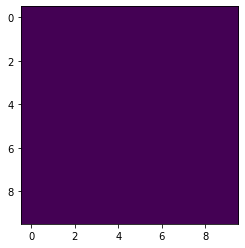

In [8]:
#先测试一下输入两个点行不行，估计是不行的，因为多边形至少三个点嘛
draw_polygon([1,1],[2,2])

竟然没有报错，但是结果也为空，说明两个点确定不了一个多边形

[[0 0 0 0 0 0 0 0 0 0]
 [0 1 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]]


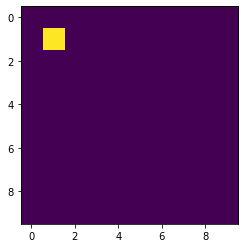

In [23]:
#测试三个点的情况
draw_polygon([1,2,2,1],[1,1,2,2])

In [26]:
help(plt.imshow)

Help on function imshow in module matplotlib.pyplot:

imshow(X, cmap=None, norm=None, aspect=None, interpolation=None, alpha=None, vmin=None, vmax=None, origin=None, extent=None, shape=<deprecated parameter>, filternorm=1, filterrad=4.0, imlim=<deprecated parameter>, resample=None, url=None, *, data=None, **kwargs)
    Display data as an image; i.e. on a 2D regular raster.
    
    The input may either be actual RGB(A) data, or 2D scalar data, which
    will be rendered as a pseudocolor image. Note: For actually displaying
    a grayscale image set up the color mapping using the parameters
    ``cmap='gray', vmin=0, vmax=255``.
    
    Parameters
    ----------
    X : array-like or PIL image
        The image data. Supported array shapes are:
    
        - (M, N): an image with scalar data. The values are mapped to
          colors using normalization and a colormap. See parameters *norm*,
          *cmap*, *vmin*, *vmax*.
        - (M, N, 3): an image with RGB values (0-1 float or 